In [1]:
portfolio_sd_t <- function(sd, cov, weight){
  stopifnot(length(sd) > 1, is.matrix(cov), length(sd) == length(weight))
  for(i in 1:(length(sd)-1)){
    for(j in (i+1):length(sd)){
      n <- sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2)
      m <- sum(2*weight[i]*weight[j]*cov[i,j])
      sd <- sqrt(sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2+
                       2*weight[i]*weight[j]*cov[i,j]))
      return(sd)
    }
  }
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns) > 1){
    mean <- apply(returns,2,mean, na.rm = T)
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [2]:
options(warn = -1)
suppressPackageStartupMessages({
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    library(tidyquant)
    library(pracma)
})

In [3]:
#Estipule os parâmetros para calcular os desvios-padrão e os retornos médios (diários e anuais)
acoes <- c("OIBR3.SA","JHSF3.SA","MEAL3.SA","SMLS3.SA","BRSR6.SA","ELET3.SA","BBAS3.SA",
          "LOGN3.SA","VALE3.SA")
retornos_d <- tq_get(acoes, from = Sys.Date()-365) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "daily")
retornos_a <- tq_get(acoes, from = Sys.Date()-365*5) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly", fill = 0) %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns") %>%
  na.fill(fill = 0)
sd_d <- retornos_d %>%
  group_by(symbol) %>%
  summarise(sd = sd(daily.returns)) %>%
  spread(key = "symbol", value = sd)
cov <- retornos_d %>%
  spread(key = "symbol", value = daily.returns)
cov$date <- NULL
cov <- cov(cov)

`summarise()` regrouping output by 'year' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [4]:
#Nº de simulações de carteiras a se fazer
n_sim <- 30000
pesos <- matrix(0,length(acoes),n_sim)
pesos <- apply(pesos,2,rexp,0.001)
pesos <- apply(pesos,2,function(x)x/sum(x))

In [5]:
time <- system.time({
    riscos <- apply(pesos, 2, portfolio_sd_t, sd = sd_d, cov = cov)*sqrt(252)
    retornos <- apply(pesos, 2, portfolio_return, returns = retornos_a[,2:ncol(retornos_a)])
})
time

   user  system elapsed 
 254.55    0.62  275.65 

In [6]:
#Sharpe
tx_livre_risco <- 0.0225
data <- data.frame(riscos = riscos, retornos = retornos, sharpe = (retornos-tx_livre_risco)/riscos)

In [7]:
#Retorno médio das ações
retorno_med <- retornos_a %>%
  data.frame %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media")

`summarise()` ungrouping output (override with `.groups` argument)



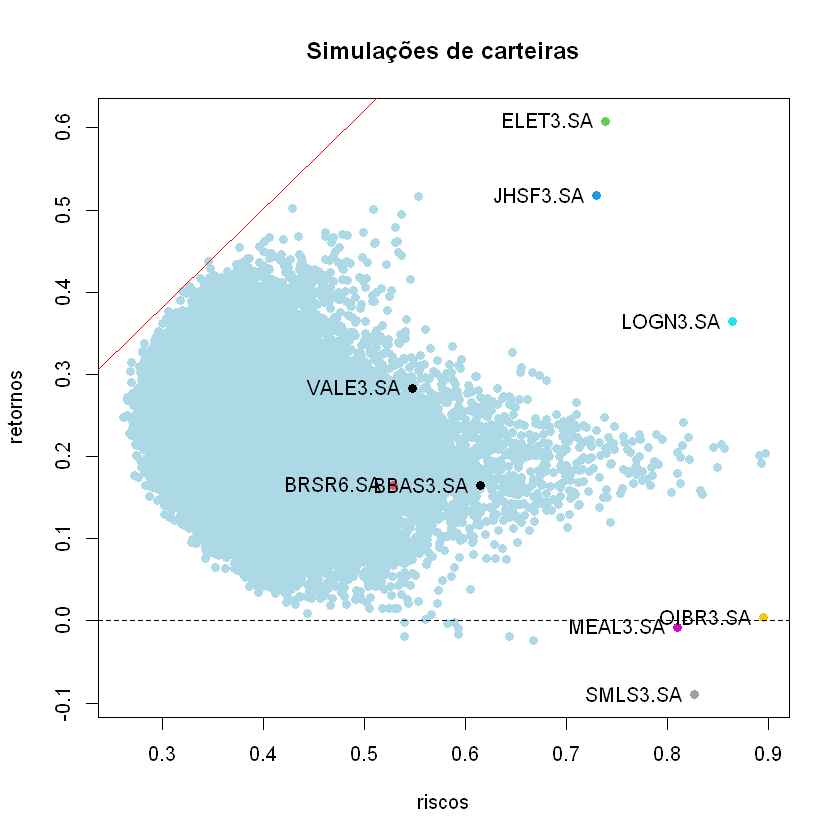

In [8]:
plot(riscos, retornos, pch = 16, col = "lightblue",xlim = c(min(riscos), max(sd_d*sqrt(252))),
    ylim = c(min(retorno_med), max(retorno_med)), main = "Simulações de carteiras")
points(x = sd_d*sqrt(252), y = retorno_med, col = 1:ncol(retorno_med), pch = 16)
text(x = sd_d*sqrt(252), y = retorno_med, labels = colnames(retorno_med), pos = 2)
abline(a = tx_livre_risco, b = max(data$sharpe), col = "red")
abline(h = 0,v = 0, lty = 2)

In [9]:
sharpe <- max(data$sharpe)
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data$retornos)
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data$riscos)
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
     1.197254

Retorno Máximo 
     0.5160616

Risco Mínimo 
   0.2624244

## Para encontrar os pesos de carteira de maior sharpe é necessário colar o maior sharpe no ctr+f, ver a linha em que está e dar print na coluna de mesmo número da matriz "pesos"

In [10]:
show(data)

         riscos     retornos        sharpe
1     0.3011332  0.167918413  0.4829039963
2     0.4646952  0.363149023  0.7330591269
3     0.3569082  0.121093851  0.2762442988
4     0.3536924  0.189678494  0.4726662911
5     0.3864244  0.236310141  0.5533039460
6     0.3842007  0.211789420  0.4926836797
7     0.3786500  0.280065084  0.6802193379
8     0.3569365  0.249430677  0.6357732873
9     0.4424520  0.343847839  0.7262886186
10    0.5956615  0.127848267  0.1768592920
11    0.4563414  0.026732972  0.0092758880
12    0.3516963  0.199604189  0.5035713378
13    0.3267624  0.183420613  0.4924697701
14    0.3318723  0.222380570  0.6022815534
15    0.2895761  0.206739644  0.6362390690
16    0.3005526  0.185152563  0.5411782963
17    0.3417932  0.216214590  0.5667595700
18    0.3814716  0.170232328  0.3872695187
19    0.5040409  0.274223847  0.4994115321
20    0.3855177  0.159808902  0.3561675718
21    0.4084993  0.362330487  0.8318997587
22    0.3244174  0.254509004  0.7151559148
23    0.352

In [11]:
pesos[,26469]*100

[1] 14.2137482  0.3301648 32.3364755 27.5563112  7.4602665  0.7046817  0.1605462
[8]  0.5046630 16.7331429

In [12]:
#Os pesos acima equivalem as ações em ordem alfabética
sort(acoes)

[1] "BBAS3.SA" "BRSR6.SA" "ELET3.SA" "JHSF3.SA" "LOGN3.SA" "MEAL3.SA" "OIBR3.SA"
[8] "SMLS3.SA" "VALE3.SA"